In [1]:
pip install numpy_financial

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import numpy_financial as npf

In [3]:
# 1. 파일 불러오기
df = pd.read_csv ('data/lending_club_2020_train.csv')

/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_29391/3038401430.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv ('data/lending_club_2020_train.csv')


In [4]:
print(df.columns.tolist())

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot

In [6]:
pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 109 kB 715 kB/s eta 0:00:01
     |████████████████████████████████| 8.4 MB 2.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# 0) 날짜/만기 정규화
df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")

def normalize_term(x):
    s = str(x)
    if "36" in s: return 36
    if "60" in s: return 60
    return pd.NA

df["term_norm"] = df["term"].apply(normalize_term)

# 1) FRED 금리 (3Y/5Y) 내려받기 — 발행 구간만
start = df["issue_d"].min() - pd.Timedelta(days=7)
end   = df["issue_d"].max() + pd.Timedelta(days=7)

rf = web.DataReader(["DGS3", "DGS5"], "fred", start, end)  # index=DATE (DatetimeIndex)
rf = rf.rename(columns={"DGS3": "rf_3y", "DGS5": "rf_5y"})  # 퍼센트 단위

# 2) issue_d를 그대로 찍어서 행 매칭 (휴일이면 직전 영업일로 대체)
#    - source(rf) 인덱스만 단조증가면 OK. df는 정렬할 필요 없음.
rf_matched = rf.reindex(df["issue_d"], method="ffill")

# 3) 행별 만기에 맞춰 risk_free 선택 후 소수 변환
df["risk_free"] = np.where(
    df["term_norm"].eq(36), rf_matched["rf_3y"] / 100.0,
    np.where(df["term_norm"].eq(60), rf_matched["rf_5y"] / 100.0, np.nan)
)

# (선택) 간단 점검
# 유효 만기 행에서 누락 몇 개?
mask = df["issue_d"].notna() & df["term_norm"].isin([36,60])
print("결측 개수:", df.loc[mask, "risk_free"].isna().sum())
print(df[["issue_d","term_norm","risk_free"]].head())


결측 개수: 160159
     issue_d term_norm  risk_free
0 2017-12-01        36     0.0190
1 2018-09-01        60     0.0274
2 2016-07-01        60     0.0100
3 2017-12-01        36     0.0190
4 2019-04-01        36     0.0229


In [8]:
df['risk_free'].dropna(inplace=True)
df['risk_free'] = df['risk_free']*(1/12)
df['risk_free'].head()

0    0.001583
1    0.002283
2    0.000833
3    0.001583
4    0.001908
Name: risk_free, dtype: float64

In [9]:
# --- 5) 결과 확인 ---
print(df[["issue_d", "term", "risk_free"]].head(10))

     issue_d        term  risk_free
0 2017-12-01   36 months   0.001583
1 2018-09-01   60 months   0.002283
2 2016-07-01   60 months   0.000833
3 2017-12-01   36 months   0.001583
4 2019-04-01   36 months   0.001908
5 2017-10-01   36 months   0.001350
6 2017-05-01   36 months   0.001233
7 2015-09-01   36 months   0.000858
8 2019-05-01   60 months   0.001925
9 2019-05-01   36 months   0.001900


In [10]:
# 부도 여부: Fully Paid → 0, Charged Off,Default → 1
status_map = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default' : 1
}
df['loan_status'] = df['loan_status'].map(status_map)

# 6.타깃값 0/1만 남기기
df = df[df['loan_status'].isin([0, 1])].copy()


In [11]:
df['loan_status'].unique()

array([0., 1.])

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 2. 날짜 형식 변환
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')  # 예: Jan-2020
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')

# 3. 개월 수 계산
df['n_months'] = df.apply(lambda row: max(1, (row['last_pymnt_d'].year - row['issue_d'].year) * 12 +
                                               (row['last_pymnt_d'].month - row['issue_d'].month)), axis=1)


# 4. IRR 계산 함수 정의
def calc_irr_by_threshold(row):
    try:
        loan_amnt = row['loan_amnt']
        term = int(row['term_norm'])
        installment = row['installment']
        recoveries = row['recoveries']
        elapsed = row['n_months']
        total_pymnt = row['total_pymnt'] # 회계 기준일에 처리된 총액
        loan_status = row['loan_status']
        last_pymnt = row['last_pymnt_amnt'] # 납부된 당일 금액
        cashflow = []
        if loan_status==0: # 부도 안냄
            if elapsed < term: # 조기상환
                if elapsed <= 1: # 1달만에 갚으면 분모가 0이 되버림 (밑에 /(elapsed-1) 때문에)
                    cashflow = [-loan_amnt] + [total_pymnt]
                else:
                    actual_monthly_payment = (total_pymnt-last_pymnt) / (elapsed-1)
                    cashflow = [-loan_amnt] + [actual_monthly_payment] * (elapsed-1) + [last_pymnt]
            else: # 정상 상환
                cashflow = [-loan_amnt] + [installment] * term
        else: # 투자했는데 부도냄
            cashflow = [-loan_amnt] + [installment] * (elapsed-1) + [last_pymnt, recoveries]
        irr_value = npf.irr(cashflow)
        return float(irr_value) if np.isfinite(irr_value) else np.nan

    except Exception as e:
        print(f"Error at row {row.name}: {e}")
        return np.nan


        
df['irr'] = df.apply(calc_irr_by_threshold, axis=1)  # y로 사용



In [13]:
df['risk_free'][:20]

0     0.001583
2     0.000833
5     0.001350
6     0.001233
7     0.000858
8     0.001925
12    0.000733
13    0.002367
14    0.002417
16    0.001225
17         NaN
18    0.000758
19    0.001217
20    0.002133
22    0.001292
23    0.001250
24    0.001292
25    0.001408
26    0.000892
27    0.001450
Name: risk_free, dtype: float64

In [14]:
df['irr'].head()

0    0.006467
2   -0.176543
5   -0.023120
6    0.009245
7    0.008325
Name: irr, dtype: float64

In [15]:
# -----------------------------
# 3) Risk-free 비교 및 파생
# -----------------------------
# risk_free는 이미 존재한다고 했으므로 그대로 사용하되, 단위 보정만

df['excess_return'] = df['irr'] - df['risk_free']

# -----------------------------
# 4) 점검
# -----------------------------
print("IRR(연환산) 평균:", df['irr'].mean())
print("IRR(연환산) 중앙값:", df['irr'].median())
print("IRR < 0 비율:", (df['irr'] < 0).mean())
print("IRR > risk_free 비율:", len(df[df['excess_return']>0]) / len(df))

cols_show = ['id', 'loan_amnt', 'installment',
             'loan_status',
             'n_months', 'irr', 'excess_return']


print(df[cols_show].head(10))

IRR(연환산) 평균: -0.014350315908610476
IRR(연환산) 중앙값: 0.009159538796039923
IRR < 0 비율: 0.1739505947197345
IRR > risk_free 비율: 0.7519262540361742
           id  loan_amnt  installment  loan_status  n_months       irr  \
0   124989905     6000.0       187.94          0.0        28  0.006467   
2    84253847    23200.0       680.82          1.0         5 -0.176543   
5   119708428    16000.0       494.55          1.0        22 -0.023120   
6   109906493     4500.0       146.10          0.0        22  0.009245   
7    60286250    20000.0       645.25          0.0        37  0.008325   
8   151871973    19000.0       482.17          1.0         1 -0.974623   
12   91934591    30000.0      1114.76          1.0        17 -0.030246   
13  144913775    16000.0       342.56          1.0         8 -0.282120   
14  141302258     6025.0       190.09          0.0        17  0.006713   
16   95487169    15000.0       542.22          0.0        17  0.015225   

    excess_return  
0        0.004883  
2    

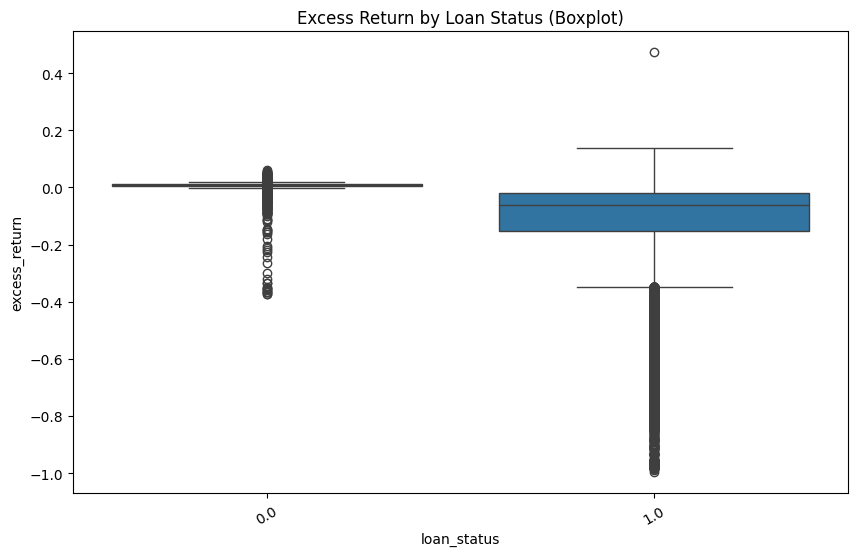

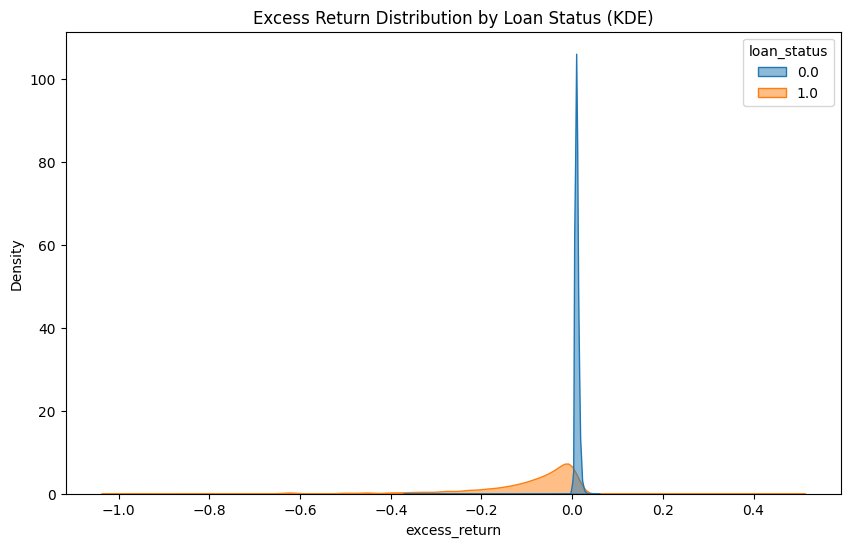

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_excess_return_by_status(df):
    """
    loan_status별 excess_return 분포 시각화
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="loan_status", y="excess_return")
    plt.title("Excess Return by Loan Status (Boxplot)")
    plt.xticks(rotation=30)
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x="excess_return", hue="loan_status", fill=True, common_norm=False, alpha=0.5)
    plt.title("Excess Return Distribution by Loan Status (KDE)")
    plt.show()
plot_excess_return_by_status(df)

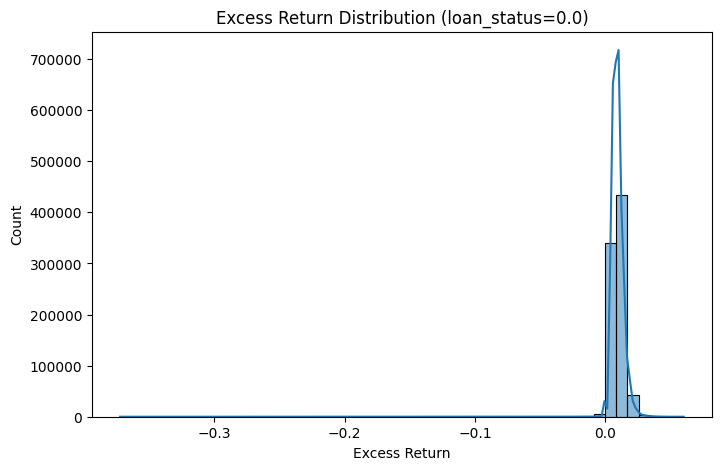

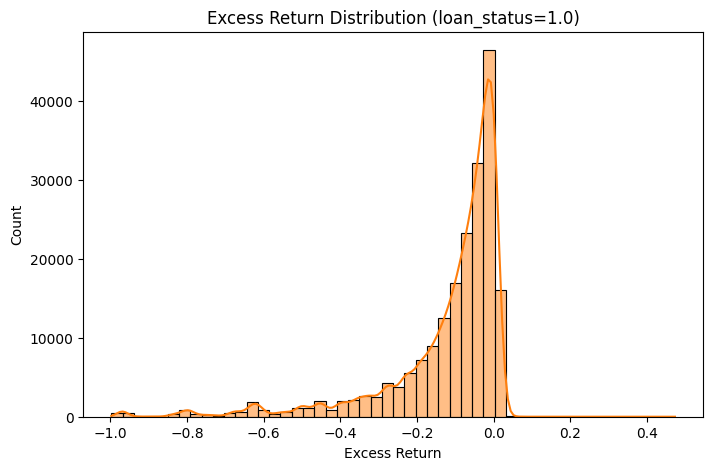

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_excess_return_separate(df):
    """
    loan_status=0, 1을 각각 따로 시각화
    """
    statuses = df['loan_status'].unique()
    
    for status in sorted(statuses):
        plt.figure(figsize=(8, 5))
        subset = df[df['loan_status'] == status]
        sns.histplot(subset['excess_return'], kde=True, bins=50, color="C0" if status==0 else "C1")
        plt.title(f"Excess Return Distribution (loan_status={status})")
        plt.xlabel("Excess Return")
        plt.ylabel("Count")
        plt.show()
plot_excess_return_separate(df)